In [1]:
import pandas as pd
import numpy as np
import matplotlib as nlp
import matplotlib.pyplot as plt
import re
import nltk
import glob
import seaborn as sns
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from math import *
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
plt.rc('figure',figsize=(17,13))
sns.set_style('darkgrid')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#read file
from google.colab import drive
drive.mount('/content/drive')
df_tweets = pd.read_csv("/content/drive/MyDrive/tweets/World Cup 2022 Tweets.csv")
# Initialize the VADER sentiment analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
# Initialize the Word2Vec model
path = "/content/drive/MyDrive/tweets/GoogleNews-vectors-negative300.bin"
model = KeyedVectors.load_word2vec_format(path, binary=True, limit=40000)
#display the first tweets
df_tweets.head()

Mounted at /content/drive


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,user_name,user_location,user_created,user_followers,user_favourites,user_verified,date,text,source
0,Craig Forrest,NaN,2011-01-14 19:09:55+00:00,20346.0,18790,TRUE,2023-01-18 15:49:26+00:00,Thanks Oso for sharing your experience at the ...,Twitter for iPhone
1,Hosayni Official,NaN,2022-06-22 23:22:12+00:00,7.0,93,FALSE,2023-01-18 15:33:42+00:00,1 month ago at #QatarWorldCup2022 #Davido 001 ...,Twitter for Android
2,꧁Jineesh Janardhanan꧂,Harippad (Alappuzha ),2019-08-25 10:32:09+00:00,2414.0,15326,FALSE,2023-01-18 14:18:42+00:00,It's been exactly a month 🏆\n#Argentina #Qatar...,Twitter for Android
3,iLOT,NaN,2021-07-15 03:20:39+00:00,3201.0,421,FALSE,2023-01-18 13:46:52+00:00,Exactly one month 🏆\n#QatarWorldCup2022 https:...,TweetDeck
4,Chanda Dalmiya,"Kolkata, India",2020-03-07 10:50:09+00:00,397.0,13600,FALSE,2023-01-18 13:46:34+00:00,@a23_fantasy Answer :- D) 6 Times\n\n#ContestA...,Twitter for Android


# Dropping columns

In [3]:
columns=df_tweets.columns
columns

Index(['user_name', 'user_location', 'user_created', 'user_followers',
       'user_favourites', 'user_verified', 'date', 'text', 'source'],
      dtype='object')

In [4]:
df_tweets.drop(['user_location','user_created','user_favourites','date','source'],axis=1,inplace=True)
df_tweets.head()

,user_name,user_followers,user_verified,text
0,Craig Forrest,20346.0,TRUE,Thanks Oso for sharing your experience at the ...
1,Hosayni Official,7.0,FALSE,1 month ago at #QatarWorldCup2022 #Davido 001 ...
2,꧁Jineesh Janardhanan꧂,2414.0,FALSE,It's been exactly a month 🏆\n#Argentina #Qatar...
3,iLOT,3201.0,FALSE,Exactly one month 🏆\n#QatarWorldCup2022 https:...
4,Chanda Dalmiya,397.0,FALSE,@a23_fantasy Answer :- D) 6 Times\n\n#ContestA...


#clearing duplicates

In [5]:
df_tweets.drop_duplicates(subset='text',inplace=True)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119970 entries, 0 to 124677
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_name       119970 non-null  object 
 1   user_followers  119969 non-null  float64
 2   user_verified   119969 non-null  object 
 3   text            119969 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.6+ MB


#deep cleaning

In [6]:
#replace all NaN values wit an empty string
df_tweets = df_tweets.replace(np.nan, '')
df_tweets.shape
# function for twitter text cleaning
def tweet_cleaner(text):
    #remove RT
    text = re.sub("RT @[\w]*:","",text)
    #remove twitter handles (@user)
    text = re.sub("(@[A-Za-z0-9_]+)","", text)
    #remove url links
    text = re.sub("https?://[A-Za-z0-9./]*","",text)
    # remove whitespaces
    text = ' '.join(text.split())
    return text
#Apply text cleaning function to text column in tweets dataframe
df_tweets['text'] = df_tweets['text'].apply(lambda x:tweet_cleaner(x))
df_tweets.shape

(119970, 4)

In [7]:
#removing shortwords
df_tweets['text']= df_tweets['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df_tweets.head(5)

,user_name,user_followers,user_verified,text
0,Craig Forrest,20346.0,TRUE,Thanks sharing your experience #QatarWorldCup2...
1,Hosayni Official,7.0,FALSE,month #QatarWorldCup2022 #Davido
2,꧁Jineesh Janardhanan꧂,2414.0,FALSE,It's been exactly month #Argentina #Qatar #Qat...
3,iLOT,3201.0,FALSE,Exactly month #QatarWorldCup2022
4,Chanda Dalmiya,397.0,FALSE,Answer Times #ContestAlert #ChaloSaathKhelein ...


In [8]:
# Define a function to calculate sentiment using VADER and Word2Vec models
def get_sentiment(text):
    # Tokenize the text and remove stop words
    tokens = [word.lower() for word in nltk.word_tokenize(text) if word.isalpha() and word.lower() not in nltk.corpus.stopwords.words('english')]
    
    # Calculate sentiment using VADER
    vader_score = sia.polarity_scores(text)['compound']
    
    # Calculate sentiment using Word2Vec
    if len(tokens) > 0:
        w2v_score = sum([model[word].sum() if word in model.key_to_index else 0 for word in tokens]) / len(tokens)
    else:
        w2v_score = 0
    
    # Combine the two scores using a weighted average
    sentiment_score = 0.7 * vader_score + 0.3 * w2v_score
    
    # Classify the sentiment based on the score
    if sentiment_score >= 0.5:
        sentiment = 'Positive'
    elif sentiment_score <= -0.5:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    
    return sentiment

# Apply the sentiment analysis function to the dataframe
df_tweets['Sentiment'] = df_tweets['text'].apply(get_sentiment)

# Print the resulting dataframe
#print(df)

In [9]:
df_tweets.head(5)

,user_name,user_followers,user_verified,text,Sentiment
0,Craig Forrest,20346.0,TRUE,Thanks sharing your experience #QatarWorldCup2...,Positive
1,Hosayni Official,7.0,FALSE,month #QatarWorldCup2022 #Davido,Neutral
2,꧁Jineesh Janardhanan꧂,2414.0,FALSE,It's been exactly month #Argentina #Qatar #Qat...,Neutral
3,iLOT,3201.0,FALSE,Exactly month #QatarWorldCup2022,Negative
4,Chanda Dalmiya,397.0,FALSE,Answer Times #ContestAlert #ChaloSaathKhelein ...,Neutral


# REMOVING PUNCTUATIONS AND MAKING TEXT LOWERCASE

In [ ]:
def clean_text(text):
    
    text = str(text).lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    return text
df_tweets['text'] = df_tweets['text'].apply(lambda x:clean_text(x))
df_tweets['text']

# Sentiment Count

In [11]:
temp = df_tweets.groupby('Sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Sentiment,text
1,Neutral,59444
2,Positive,42855
0,Negative,17671


# FUNNEL CHART FOR BETTER VISUALIZATION OF SENTIMENT DISTRIBUTION

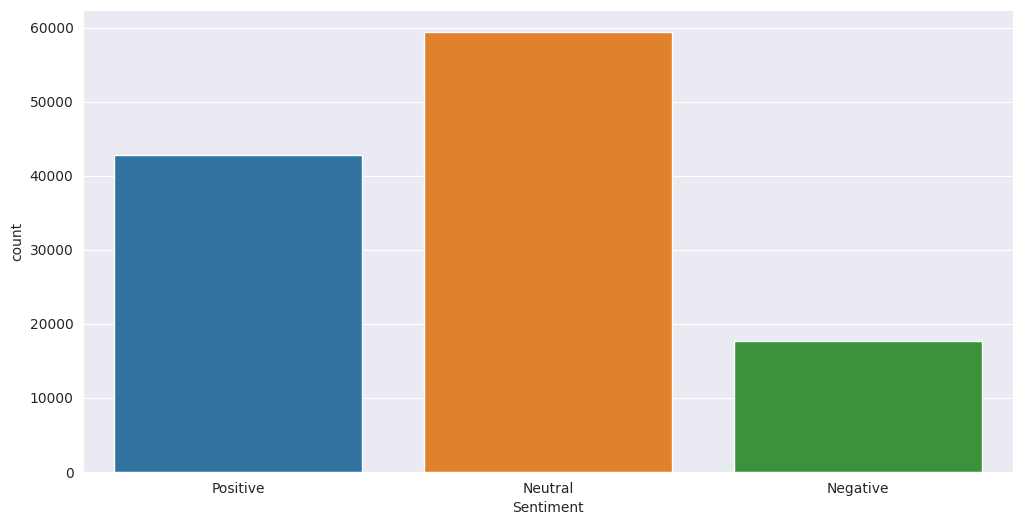

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=df_tweets)
fig = go.Figure(go.Funnelarea(
    text = temp.Sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

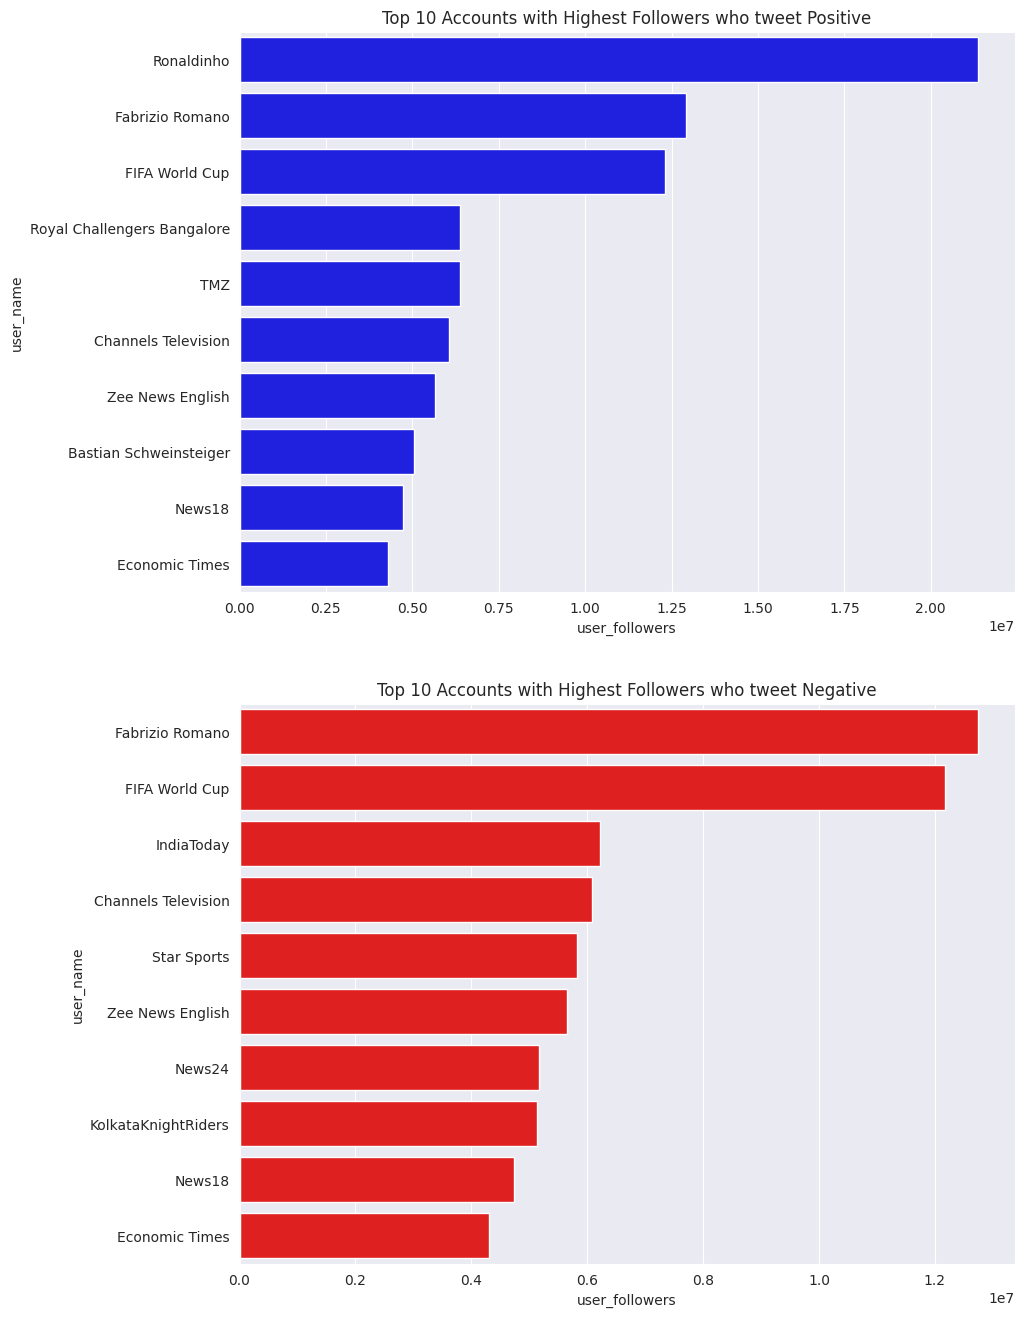

In [13]:
from matplotlib import rcParams

fig, (ax1, ax3) = plt.subplots(2,1, figsize=(10, 16))
sns.barplot(x="user_followers", y="user_name", orient="h", ax=ax1, palette=["b"],
           data=df_tweets[(df_tweets.Sentiment== "Positive")]\
           .drop_duplicates(subset=["user_name"])\
           .sort_values(by=["user_followers"], ascending=False)[["user_name", "user_followers"]][:10])
ax1.set_title('Top 10 Accounts with Highest Followers who tweet Positive')

sns.barplot(x="user_followers", y="user_name", orient="h", ax=ax3, palette=["r"],
           data=df_tweets[(df_tweets.Sentiment == "Negative")]
           .drop_duplicates(subset=["user_name"])\
           .sort_values(by=["user_followers"], ascending=False)[["user_name", "user_followers"]][:10])
ax3.set_title('Top 10 Accounts with Highest Followers who tweet Negative')

fig.show()

# Checking Model Accuracy

In [14]:
y=df_tweets['Sentiment']
df_tweets = df_tweets.replace(['Positive','Neutral','Negative'],[2, 1, 0])
df_tweets.head()

,user_name,user_followers,user_verified,text,Sentiment
0,Craig Forrest,20346.0,TRUE,thanks sharing your experience qatarworldcup20...,2
1,Hosayni Official,7.0,FALSE,month qatarworldcup2022 davido,1
2,꧁Jineesh Janardhanan꧂,2414.0,FALSE,its been exactly month argentina qatar qatarwo...,1
3,iLOT,3201.0,FALSE,exactly month qatarworldcup2022,0
4,Chanda Dalmiya,397.0,FALSE,answer times contestalert chalosaathkhelein a2...,1


In [15]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df_tweets['text'].values.astype('U'))
X=text_counts
y=df_tweets['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=19)
cnb = ComplementNB()
cnb.fit(X_train, y_train)
cross_cnb = cross_val_score(cnb, X, y,n_jobs = -1)
print("Cross Validation score = ",cross_cnb)                
print ("Train accuracy ={:.2f}%".format(cnb.score(X_train,y_train)*100))
print ("Test accuracy ={:.2f}%".format(cnb.score(X_test,y_test)*100))
train_acc_cnb=cnb.score(X_train,y_train)
test_acc_cnb=cnb.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Cross Validation score =  [0.53446695 0.51250313 0.57685255 0.57572727 0.62511461]
Train accuracy =76.83%
Test accuracy =67.41%


In [16]:
from sklearn.metrics import *
#Predict test data set
y_pred_cnb =cnb.predict(X_test)

#This is the confusion matrix :
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred_cnb))

[[2360  841  351]
 [1862 6797 3257]
 [ 437 1071 7018]]


In [17]:
#Checking performance our model with classification report
print(classification_report(y_test, y_pred_cnb))

              precision    recall  f1-score   support

           0       0.51      0.66      0.57      3552
           1       0.78      0.57      0.66     11916
           2       0.66      0.82      0.73      8526

    accuracy                           0.67     23994
   macro avg       0.65      0.69      0.66     23994
weighted avg       0.70      0.67      0.67     23994



In [18]:
from sklearn.metrics import *

print("F1 score ={:.2f}%".format(f1_score(y_test, y_pred_cnb, average="macro")*100))
f1_cnb=f1_score(y_test, y_pred_cnb, average="macro")
print("Precision score ={:.2f}%".format(precision_score(y_test, y_pred_cnb, average="macro")*100))
precision_cnb=precision_score(y_test, y_pred_cnb, average="macro")
print("Recall score ={:.2f}%".format(recall_score(y_test, y_pred_cnb, average="macro")*100))  
recall_cnb=recall_score(y_test, y_pred_cnb, average="macro")

F1 score =65.56%
Precision score =64.92%
Recall score =68.60%
